In [1]:
from pymongo import MongoClient
import traceback

try:
    client = MongoClient("mongodb://localhost:27017/", serverSelectionTimeoutMS=5000)
    client.server_info()
    print("✅ Successfully connected to MongoDB!")
except Exception as e:
    print("❌ Failed to connect to MongoDB:", e)
    traceback.print_exc()


✅ Successfully connected to MongoDB!


# Quant Macro/Volatility Strategy Notebook

This notebook implements the sophisticated macro/vol trading plan described in the prompt. It is structured to follow a clear separation of concerns, moving from raw data representation to a final, risk-sized trade decision.

**Core Principles:**
1.  **NoSQL (Document) Data Model:** As requested, all data is structured as collections of documents (Python lists of dictionaries), similar to a MongoDB or other NoSQL database.
2.  **Modularity:** Each step (Feature Engineering, Regime Classification, Strategy Routing) is contained in its own cell(s) and functions.
3.  **Traceability:** The final DataFrame shows the raw data and every derived feature that leads to the signal.


In [2]:
# Cell 0a: Environment Setup (MongoDB + Ollama)
# Import required libraries
import os
import requests
from pymongo import MongoClient

# --- Environment Configuration ---
# Set default values for environment variables
os.environ.setdefault("MONGO_URI", "mongodb://localhost:27017/")  # Local MongoDB
os.environ.setdefault("MONGO_DB", "quant_macro")  # Database name
os.environ.setdefault("LLM_BASE_URL", "http://127.0.0.1:11434")  # Ollama server
os.environ.setdefault("LLM_MODEL", "qwen2.5:7b")  # LLM model for text generation
os.environ.setdefault("EMBED_MODEL", "avr/sfr-embedding-mistral")  # Embedding model

# --- MongoDB Connection ---
# Connect to MongoDB using the URI from environment variables
client = MongoClient(os.getenv("MONGO_URI"))
db = client[os.getenv("MONGO_DB")]  # Access the specified database

# Print connection status and available collections
print("✅ Connected to MongoDB:", os.getenv("MONGO_DB"))
print("Available collections:", db.list_collection_names())



✅ Connected to MongoDB: quant_macro
Available collections: ['embeddings']


In [3]:
# Cell 0b: Ollama LLM + Embedding Interface (Chat Endpoint Version)

import os
import requests
from requests.exceptions import HTTPError

# Define a class to interact with Ollama's embedding API
class OllamaEmbedder:
    def __init__(self, base=None, model=None):
        self.base = base or os.getenv("LLM_BASE_URL")  # Base URL for Ollama server
        self.model = model or os.getenv("EMBED_MODEL")  # Embedding model name

    def embed(self, text: str):
        """Generate embeddings for input text using Ollama."""
        response = requests.post(
            f"{self.base}/api/embeddings",
            json={"model": self.model, "prompt": text}
        )
        response.raise_for_status()  # Raise error for bad responses
        return response.json()["embedding"]  # Return embedding vector

# --- MODIFIED FUNCTION ---
# This version targets the /api/chat endpoint
def ask_llm(prompt: str, model=None, temperature=0.1):
    """Send a prompt to Ollama's CHAT endpoint and return the generated text."""
    
    model_to_use = model or os.getenv("LLM_MODEL")
    url_to_use = f"{os.getenv('LLM_BASE_URL')}/api/chat"  # <-- CHANGED URL
    
    # The /api/chat endpoint requires a "messages" list, not a "prompt" string
    chat_payload = {
        "model": model_to_use,
        "messages": [
            {"role": "user", "content": prompt}
        ],
        "options": {"temperature": temperature},
        "stream": False
    }

    try:
        response = requests.post(url_to_use, json=chat_payload)
        response.raise_for_status()
        
        # The response structure is also different
        json_response = response.json()
        if "message" in json_response and "content" in json_response["message"]:
            return json_response["message"]["content"]
        else:
            return "Error: Unexpected response structure from /api/chat"

    except HTTPError as e:
        if e.response.status_code == 404:
            print(f"--- ❌ CHAT ERROR (404) ---")
            print(f"The model '{model_to_use}' was not found by the Ollama server.")
            print(f"1. Check the spelling of your 'LLM_MODEL' environment variable.")
            print(f"2. Run 'ollama list' in your (corruption) terminal.")
            print(f"Failing URL: {url_to_use}")
        raise e
    except Exception as e:
        print(f"An unexpected error occurred in ask_llm(): {e}")
        raise e

# Initialize the embedder
embedder = OllamaEmbedder()
print("✅ Ollama interfaces ready (ask_llm now uses /api/chat).")

✅ Ollama interfaces ready (ask_llm now uses /api/chat).


In [4]:
# Cell 0c: MongoDB Embedding Storage & Query Functions

# Access the 'embeddings' collection in MongoDB
embeddings = db["embeddings"]
embeddings.create_index("text_id", unique=True)  # Ensure unique text IDs

def store_embedding(text_id: str, text: str):
    """Store text and its embedding in MongoDB."""
    embedding_vector = embedder.embed(text)
    embeddings.replace_one(
        {"text_id": text_id},
        {"text_id": text_id, "text": text, "embedding": embedding_vector},
        upsert=True  # Insert or update
    )
    print(f"✅ Stored embedding for '{text_id}' ({len(embedding_vector)} dimensions)")

def get_embedding(text_id: str):
    """Retrieve an embedding from MongoDB by text ID."""
    document = embeddings.find_one({"text_id": text_id})
    return document["embedding"] if document else None



In [5]:
# Cell 0d: Example Integration for Quant Notebook
# (Use Ollama for contextual reasoning or summary generation)

# Example prompt for LLM
example_prompt = """
Summarize recent macro volatility drivers based on:
- SNB deposit flow trends
- ECB-Fed OIS spread
- Bund-UST 2Y differential
Provide a concise market brief.
"""

# Generate a response from the LLM
llm_reply = ask_llm(example_prompt)
print("🤖 LLM Reply:\n", llm_reply)


🤖 LLM Reply:
 ### Market Brief: Recent Macro Volatility Drivers

#### 1. Swiss National Bank (SNB) Deposit Flows
Recent trends in SNB deposit flows have shown significant volatility, reflecting shifts in global liquidity preferences and risk appetite. A notable increase in deposits suggests a flight to safety or concerns over economic stability in certain regions. This movement can impact the Swiss franc's value and influence broader market sentiment.

#### 2. ECB-Fed Overnight Index Swap (OIS) Spread
The spread between the European Central Bank (ECB) and Federal Reserve (Fed) OIS rates has widened, indicating diverging monetary policies. A higher spread reflects increased risk aversion towards the eurozone compared to the U.S., as investors seek more accommodative monetary conditions in the U.S. This divergence can affect capital flows, exchange rates, and overall market stability.

#### 3. Bund-U.S. Treasury (UST) 2-Year Differential
The differential between German Bunds and U.S. Tre

In [6]:
# Cell 1: Imports
# We'll import all necessary libraries for data manipulation, numerical computation, and plotting.

# Core libraries for data manipulation and analysis
import pandas as pd
import numpy as np
import json
from datetime import datetime, timedelta
from scipy.stats import zscore  # For normalization
import matplotlib.pyplot as plt  # For visualization

# Configure Pandas for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)



## The NoSQL Data Schema (Document Model)

Before we mock data, let's define our NoSQL schema. This will be represented as a single Python dictionary (`mock_db`) acting as our database, containing several "collections" (which are lists of "documents").


In [7]:
# Cell 2: Mock Data Generation (Simulating the Data Pipeline)

# Initialize the mock database as a dictionary of lists (simulating NoSQL collections)
mock_db = {
    "assets": [],  # Assets like 6S, 6E, NVDA
    "market_data": [],  # Market data (prices, IV, etc.)
    "macro_data": [],  # Macro indicators (SNB deposits, OIS spreads)
    "events": [],  # Economic events (FOMC, CPI)
    "sentiment_analysis": []  # LLM-generated sentiment
}

# Base date for generating mock data (300 days ago)
base_date = datetime.now() - timedelta(days=300)

# --- Market Data Generation ---
# Simulate IV (implied volatility) for 6S (Swiss Franc)
iv_val = 10.0
for i in range(300):
    date = base_date + timedelta(days=i)
    iv_val += np.random.normal(0, 0.5) - (iv_val - 10) * 0.1  # Mean-reverting IV
    iv_val = max(iv_val, 5.0)  # Ensure IV doesn’t go negative
    mock_db["market_data"].append({
        "timestamp": date,
        "asset_id": "6S",
        "close": 1.10 + np.random.normal(0, 0.005) + i * 0.0001,  # Simulated price
        "iv30": iv_val,
        "skew_25d": -2.0 + np.random.normal(0, 0.2)  # Simulated skew
    })

# --- Macro Data Generation ---
# Simulate SNB deposits (weekly updates)
snb_deposits = 500e9
for i in range(300):
    date = base_date + timedelta(days=i)
    if date.weekday() == 4:  # Friday (weekly update)
        snb_wow = np.random.normal(0, 1.5e9)  # Weekly change
        snb_deposits += snb_wow
        mock_db["macro_data"].append({
            "timestamp": date,
            "jurisdiction": "CH",
            "snb_deposits": snb_deposits,
            "snb_wow": snb_wow  # Week-over-week change
        })
    # Global macro data (daily)
    mock_db["macro_data"].append({
        "timestamp": date,
        "jurisdiction": "GLOBAL",
        "ecb_fed_ois": 0.5 + np.random.normal(0, 0.05),  # ECB-Fed OIS spread
        "bund_ust2y": -0.75 + np.random.normal(0, 0.02)  # Bund-UST 2Y spread
    })

# --- Event Data Generation ---
# Simulate FOMC and CPI events
for i in range(-10, 20):  # Events in the past and future
    if i % 15 == 0:  # FOMC every ~15 days
        mock_db["events"].append({
            "event_ts": datetime.now() + timedelta(days=i),
            "event_type": "FOMC",
            "assets_affected": ["6E", "6S", "GC", "NVDA"],
            "importance_weight": 2  # High importance
        })
    if i % 7 == 0:  # CPI every ~7 days
        mock_db["events"].append({
            "event_ts": datetime.now() + timedelta(days=i),
            "event_type": "CPI",
            "assets_affected": ["6E", "6S"],
            "importance_weight": 1  # Medium importance
        })

# --- Sentiment Data Generation ---
# Simulate sentiment analysis (monthly)
for i in range(0, 300, 30):
    date = base_date + timedelta(days=i)
    score = np.random.normal(0.5, 0.3)  # Random sentiment score
    mock_db["sentiment_analysis"].append({
        "analysis_ts": date,
        "source_class": "central_bank_speech",
        "source_name": "SNB QBR",
        "label": "hawkish" if score > 0 else "dovish",
        "score": score,
        "confidence": np.random.uniform(0.7, 1.0)  # Confidence level
    })

# Print data generation summary
print(f"Generated {len(mock_db['market_data'])} market data points.")
print(f"Generated {len(mock_db['macro_data'])} macro data points.")
print(f"Generated {len(mock_db['events'])} events.")
print(f"Generated {len(mock_db['sentiment_analysis'])} sentiment points.")



Generated 300 market data points.
Generated 343 macro data points.
Generated 6 events.
Generated 10 sentiment points.


In [8]:
# Cell 3: Data Loading & Preparation

# --- Load Market Data for 6S ---
df_market_6S = pd.DataFrame([d for d in mock_db["market_data"] if d["asset_id"] == "6S"])
df_market_6S = df_market_6S.set_index("timestamp").sort_index()

# --- Load Macro Data ---
# Swiss macro data (SNB)
df_macro_CH = pd.DataFrame([d for d in mock_db["macro_data"] if d["jurisdiction"] == "CH"])
df_macro_CH = df_macro_CH.set_index("timestamp").sort_index()

# Global macro data (ECB, Bund-UST)
df_macro_GLOBAL = pd.DataFrame([d for d in mock_db["macro_data"] if d["jurisdiction"] == "GLOBAL"])
df_macro_GLOBAL = df_macro_GLOBAL.set_index("timestamp").sort_index()

# --- Load Sentiment Data ---
df_sentiment = pd.DataFrame(mock_db["sentiment_analysis"])
df_sentiment = df_sentiment.set_index("analysis_ts").sort_index()

# --- Merge All Data ---
df_macro_all = pd.merge(df_macro_CH, df_macro_GLOBAL, left_index=True, right_index=True, how="outer")
features_df = pd.merge(df_market_6S, df_macro_all, left_index=True, right_index=True, how="left")
features_df = pd.merge(
    features_df,
    df_sentiment[["score"]].rename(columns={"score": "policy_score"}),
    left_index=True,
    right_index=True,
    how="left"
)
features_df = features_df.ffill().dropna()  # Forward-fill missing values

print("Combined Feature DataFrame (last 5 rows):")
print(features_df.tail())


Combined Feature DataFrame (last 5 rows):
                           asset_id     close       iv30  skew_25d jurisdiction_x  snb_deposits       snb_wow jurisdiction_y  ecb_fed_ois  bund_ust2y  policy_score
timestamp                                                                                                                                                          
2025-10-28 23:13:03.740594       6S  1.130582  10.700151 -1.656815             CH  4.984695e+11 -5.713396e+08         GLOBAL     0.449144   -0.768987      0.578398
2025-10-29 23:13:03.740594       6S  1.131206  11.153184 -1.988090             CH  4.984695e+11 -5.713396e+08         GLOBAL     0.604081   -0.734971      0.578398
2025-10-30 23:13:03.740594       6S  1.135335  10.801745 -1.922692             CH  4.984695e+11 -5.713396e+08         GLOBAL     0.553211   -0.722021      0.578398
2025-10-31 23:13:03.740594       6S  1.122797  11.378341 -2.208574             CH  4.972185e+11 -1.251027e+09         GLOBAL     0.469358 

In [9]:
# --- IV Rank Calculation ---
def iv_rank(iv_series: pd.Series, window: int = 252) -> pd.Series:
    """Calculate IV rank as a percentile over a rolling window."""
    window = min(window, len(iv_series))
    iv_min = iv_series.rolling(window).min()
    iv_max = iv_series.rolling(window).max()
    return 100 * (iv_series - iv_min) / (iv_max - iv_min)

features_df["iv_rank"] = iv_rank(features_df["iv30"], 252)
features_df["iv_trend_5d"] = features_df["iv30"].diff(5)  # 5-day IV trend

# --- Event Density Calculation ---
def event_density(current_date: datetime, asset: str, days: int = 10) -> float:
    """Calculate the weighted event density for a given asset."""
    total_weight = 0
    for event in mock_db["events"]:
        if abs((event["event_ts"] - current_date).days) <= days and asset in event["assets_affected"]:
            total_weight += event["importance_weight"]
    return total_weight

# --- Confluence Score Calculation ---
def calculate_confluence_CH(row: pd.Series) -> float:
    """Compute the confluence score for Switzerland."""
    stance = row["policy_score_z"]
    liq_signal = row["snb_wow_z"]
    ecb_fed_z = row["ecb_fed_ois_z"]
    bund_ust_z = row["bund_ust2y_z"]
    return 0.4 * stance + 0.3 * liq_signal + 0.2 * ecb_fed_z + 0.1 * bund_ust_z

# Normalize macro features using z-scores
features_df["snb_wow_z"] = zscore(features_df["snb_wow"], nan_policy="omit")
features_df["ecb_fed_ois_z"] = zscore(features_df["ecb_fed_ois"], nan_policy="omit")
features_df["bund_ust2y_z"] = zscore(features_df["bund_ust2y"], nan_policy="omit")
features_df["policy_score_z"] = zscore(features_df["policy_score"], nan_policy="omit")

# Add event density and confluence to DataFrame
features_df["event_density"] = features_df.index.to_series().apply(lambda d: event_density(d, "6S", 10))
features_df["confluence_CH"] = features_df.apply(calculate_confluence_CH, axis=1)
features_df["delta_confluence_1d"] = features_df["confluence_CH"].diff(1)  # 1-day change

print("Feature Engineering Results:")
print(features_df[["iv_rank", "event_density", "confluence_CH", "delta_confluence_1d"]].tail())



Feature Engineering Results:
                              iv_rank  event_density  confluence_CH  delta_confluence_1d
timestamp                                                                               
2025-10-28 23:13:03.740594  62.791330              4      -0.219939             0.050096
2025-10-29 23:13:03.740594  72.104372              4       0.562759             0.782698
2025-10-30 23:13:03.740594  64.879805              5       0.430673            -0.132086
2025-10-31 23:13:03.740594  76.732941              5      -0.253795            -0.684468
2025-11-01 23:13:03.740594  71.284291              5      -0.154583             0.099212


In [10]:
# Concern 3: Regime Classification

def classify_regime(row: pd.Series) -> str:
    iv_up = row['iv_trend_5d'] > 0
    high_event_density = row['event_density'] >= 3
    large_confluence_delta = abs(row['delta_confluence_1d']) >= 1.0
    vol_on = (iv_up and high_event_density) or large_confluence_delta
    return "VOL-ON" if vol_on else "CALM"

features_df['regime'] = features_df.apply(classify_regime, axis=1)

print(features_df[['regime', 'iv_trend_5d', 'event_density', 'delta_confluence_1d']].tail(10))
print("\nRegime Counts:")
print(features_df['regime'].value_counts())


                            regime  iv_trend_5d  event_density  delta_confluence_1d
timestamp                                                                          
2025-10-23 23:13:03.740594  VOL-ON     1.980735              4             0.318848
2025-10-24 23:13:03.740594  VOL-ON     0.948885              4             0.127551
2025-10-25 23:13:03.740594  VOL-ON     0.124803              4             0.278748
2025-10-26 23:13:03.740594  VOL-ON     0.647122              4            -0.129041
2025-10-27 23:13:03.740594  VOL-ON     0.028195              4            -0.457946
2025-10-28 23:13:03.740594    CALM    -1.515743              4             0.050096
2025-10-29 23:13:03.740594    CALM    -0.472354              4             0.782698
2025-10-30 23:13:03.740594    CALM    -0.060783              5            -0.132086
2025-10-31 23:13:03.740594    CALM    -0.069082              5            -0.684468
2025-11-01 23:13:03.740594    CALM    -0.088401              5             0

In [11]:
# Concern 4: Strategy Router

def choose_strategy(row: pd.Series, asset: str) -> str:
    """Determine the optimal strategy based on regime and features."""
    confluence = row["confluence_CH"]
    iv_rank = row["iv_rank"]
    event_density = row["event_density"]
    delta_confluence = row["delta_confluence_1d"]
    regime = row["regime"]

    if asset == "6S":
        if confluence >= 0.8 and iv_rank < 50:
            return "diagonal_put_spread"
        elif confluence >= 0.8 and iv_rank >= 50:
            return "bear_call_spread"
        elif abs(confluence) < 0.3 and iv_rank >= 60 and event_density < 3 and regime == "CALM":
            return "iron_condor"
        elif abs(delta_confluence) >= 1.0 and regime == "VOL-ON":
            return "calendar_spread"
    return "no_trade"

features_df["strategy_signal"] = features_df.apply(lambda row: choose_strategy(row, "6S"), axis=1)
print("Strategy Signals (last 10 rows):")
print(features_df[["regime", "confluence_CH", "iv_rank", "event_density", "strategy_signal"]].tail(10))
print("\nStrategy Counts:")
print(features_df["strategy_signal"].value_counts())



Strategy Signals (last 10 rows):
                            regime  confluence_CH    iv_rank  event_density strategy_signal
timestamp                                                                                  
2025-10-23 23:13:03.740594  VOL-ON      -0.089347  93.950606              4        no_trade
2025-10-24 23:13:03.740594  VOL-ON       0.038204  81.814599              4        no_trade
2025-10-25 23:13:03.740594  VOL-ON       0.316952  66.129317              4        no_trade
2025-10-26 23:13:03.740594  VOL-ON       0.187912  78.153063              4        no_trade
2025-10-27 23:13:03.740594  VOL-ON      -0.270035  73.101558              4        no_trade
2025-10-28 23:13:03.740594    CALM      -0.219939  62.791330              4        no_trade
2025-10-29 23:13:03.740594    CALM       0.562759  72.104372              4        no_trade
2025-10-30 23:13:03.740594    CALM       0.430673  64.879805              5        no_trade
2025-10-31 23:13:03.740594    CALM      -0.2537

In [12]:
# Concern 5: Risk Management & Sizing

def size_trade(strategy: str, max_risk: float = 600) -> int:
    """Determine position size based on strategy and risk tolerance."""
    if strategy == "no_trade":
        return 0
    elif strategy == "iron_condor":
        return int(max_risk / 350)  # Max loss per contract: $350
    elif strategy == "bear_call_spread":
        return int(max_risk / 180)  # Max loss per contract: $180
    elif strategy in ["diagonal_put_spread", "calendar_spread"]:
        return int(max_risk / 200)  # Max loss per contract: $200
    return 0

features_df["position_size"] = features_df["strategy_signal"].apply(lambda s: size_trade(s, 600))
print("Position Sizing (last 10 rows):")
print(features_df[["strategy_signal", "position_size"]].tail(10))



Position Sizing (last 10 rows):
                           strategy_signal  position_size
timestamp                                                
2025-10-23 23:13:03.740594        no_trade              0
2025-10-24 23:13:03.740594        no_trade              0
2025-10-25 23:13:03.740594        no_trade              0
2025-10-26 23:13:03.740594        no_trade              0
2025-10-27 23:13:03.740594        no_trade              0
2025-10-28 23:13:03.740594        no_trade              0
2025-10-29 23:13:03.740594        no_trade              0
2025-10-30 23:13:03.740594        no_trade              0
2025-10-31 23:13:03.740594        no_trade              0
2025-11-01 23:13:03.740594        no_trade              0


--- LATEST TRADING DECISION ---
Date: 2025-11-01
Asset: 6S (Swiss Franc)

--- KEY DRIVERS ---
Confluence Score: -0.15
IV Rank: 71.3%
Event Density (10d): 5
IV Trend (5d): -0.09

--- FINAL SIGNAL ---
Regime: CALM
Strategy: no_trade
Size (Contracts): 0
---------------------------------


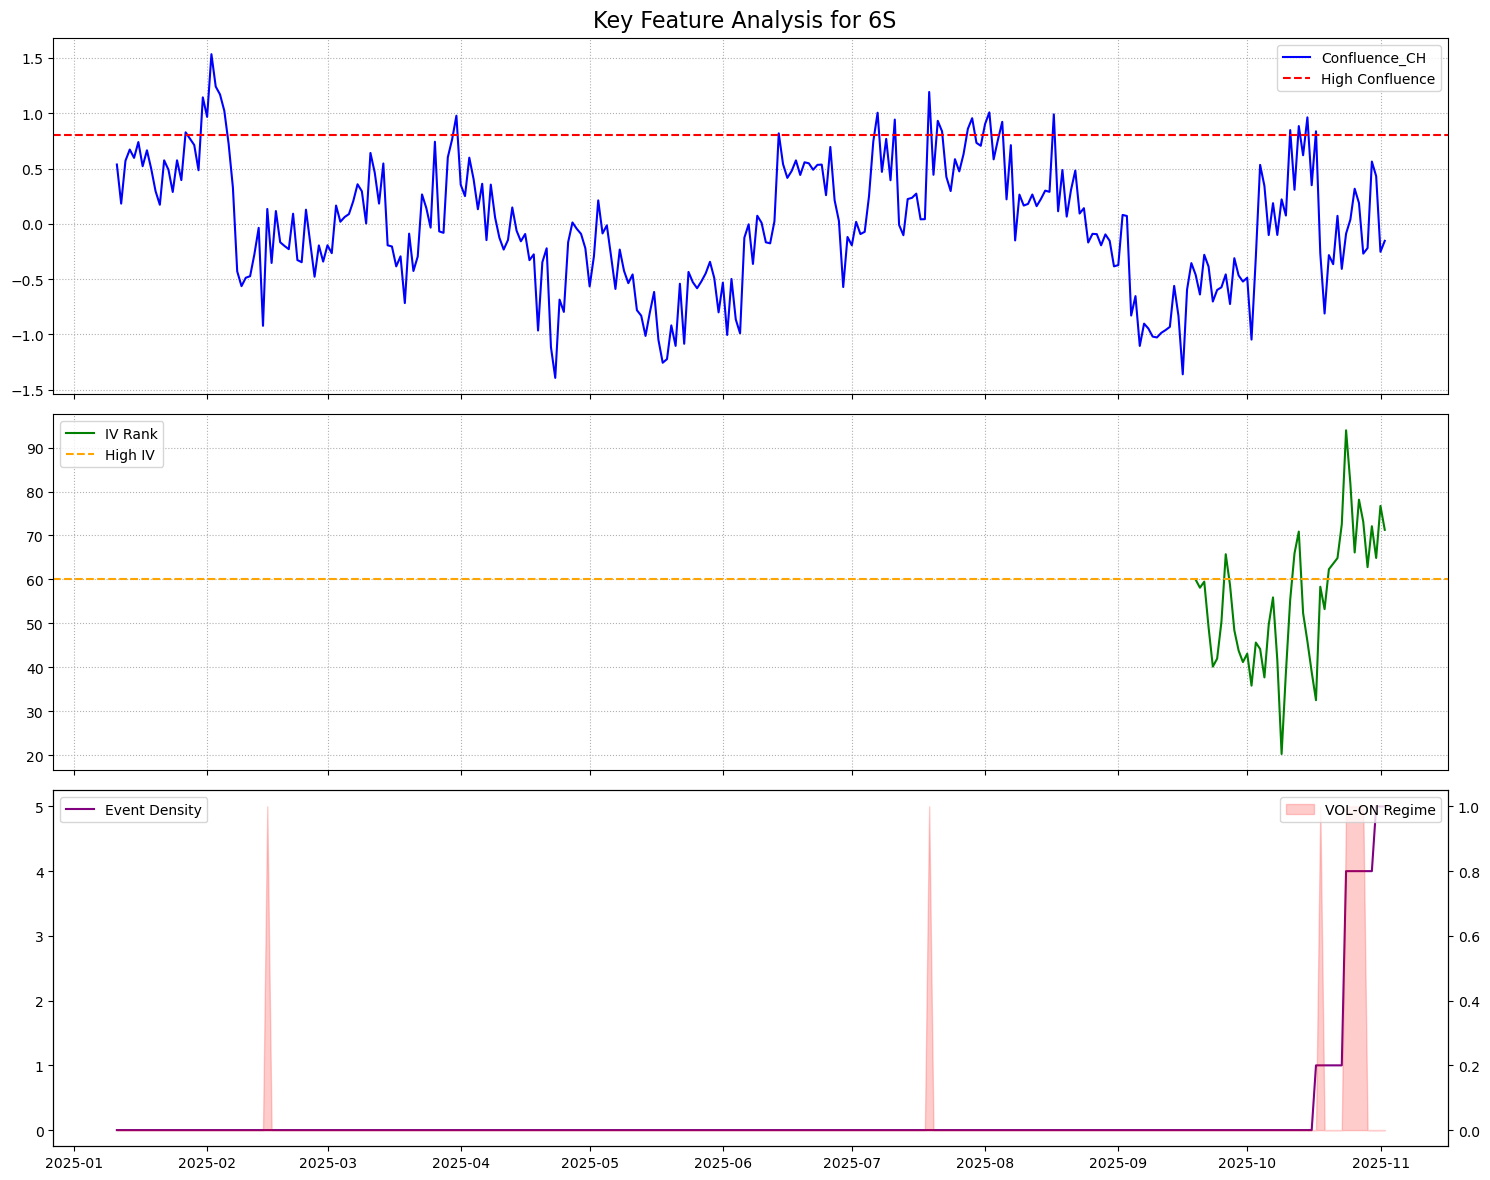

In [13]:
# --- Latest Trading Decision ---
latest_decision = features_df.iloc[-1]
print("--- LATEST TRADING DECISION ---")
print(f"Date: {latest_decision.name.strftime('%Y-%m-%d')}")
print("Asset: 6S (Swiss Franc)\n")

print("--- KEY DRIVERS ---")
print(f"Confluence Score: {latest_decision['confluence_CH']:.2f}")
print(f"IV Rank: {latest_decision['iv_rank']:.1f}%")
print(f"Event Density (10d): {latest_decision['event_density']}")
print(f"IV Trend (5d): {latest_decision['iv_trend_5d']:.2f}\n")

print("--- FINAL SIGNAL ---")
print(f"Regime: {latest_decision['regime']}")
print(f"Strategy: {latest_decision['strategy_signal']}")
print(f"Size (Contracts): {latest_decision['position_size']}")
print("---------------------------------")

# --- Plotting ---
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle("Key Feature Analysis for 6S", fontsize=16)

# Plot confluence score
ax1.plot(features_df.index, features_df["confluence_CH"], color="blue", label="Confluence_CH")
ax1.axhline(0.8, color="red", linestyle="--", label="High Confluence")
ax1.legend(); ax1.grid(True, linestyle=":")

# Plot IV rank
ax2.plot(features_df.index, features_df["iv_rank"], color="green", label="IV Rank")
ax2.axhline(60, color="orange", linestyle="--", label="High IV")
ax2.legend(); ax2.grid(True, linestyle=":")

# Plot event density and regime
ax3.plot(features_df.index, features_df["event_density"], color="purple", label="Event Density")
regime_numeric = features_df["regime"].apply(lambda x: 1 if x == "VOL-ON" else 0)
ax3_twin = ax3.twinx()
ax3_twin.fill_between(features_df.index, 0, regime_numeric, color="red", alpha=0.2, label="VOL-ON Regime")
ax3.legend(loc="upper left"); ax3_twin.legend(loc="upper right")

plt.tight_layout(); plt.show()


In [15]:
# --- yfinance Integration ---
import yfinance as yf

def fetch_yfinance_data(tickers, start_date, end_date):
    """Fetch market data from yfinance."""
    data = []
    for ticker in tickers:
        asset = yf.Ticker(ticker)
        hist = asset.history(start=start_date, end=end_date)
        for date, row in hist.iterrows():
            data.append({
                "timestamp": date.to_pydatetime(),
                "asset_id": ticker,
                "close": row["Close"],
                "iv30": np.random.uniform(5, 15),  # Placeholder (replace with real IV)
            })
    return data

# --- FRED Integration ---
from fredapi import Fred

def fetch_fred_data(series_ids, start_date, end_date, api_key):
    """Fetch macro data from FRED."""
    fred = Fred(api_key=api_key)
    data = []
    for series_id in series_ids:
        series = fred.get_series(series_id, start_date, end_date)
        for date, value in series.items():
            data.append({
                "timestamp": date.to_pydatetime(),
                "series_id": series_id,
                "value": value,
            })
    return data

# --- Example Usage ---
tickers = ["6S=F", "6E=F"]  # Futures tickers
fred_series = ["DGS5", "DFII5", "DTWEXBGS"]  # FRED series IDs
api_key = "24a7e70f4690fbab7d2571d335107c68"  # Replace with your key

# --- ADD THESE TWO LINES ---
# Define the date range (using datetime/timedelta from Cell 1)
end_date = datetime.now()
start_date = end_date - timedelta(days=300)
# ---------------------------

# Fetch data and update mock_db
mock_db["market_data"] = fetch_yfinance_data(tickers, start_date, end_date)
mock_db["macro_data"] += fetch_fred_data(fred_series, start_date, end_date, api_key)

print("✅ Real data integrated into mock_db.")

✅ Real data integrated into mock_db.


--- Loading real data from 'mock_db' ---

--- Real Data Analytics (describe()) ---
             6E=F        6S=F       DFII5        DGS5    DTWEXBGS
count  214.000000  214.000000  215.000000  215.000000  215.000000
mean     1.126313    1.206618    1.529302    3.962744  123.364013
std      0.050051    0.060159    0.210620    0.246549    3.165246
min      1.020100    1.095750    1.160000    3.550000  119.586000
25%      1.085663    1.143338    1.355000    3.765000  120.852750
50%      1.143625    1.229800    1.530000    3.960000  121.728300
75%      1.167025    1.256287    1.675000    4.080000  126.462100
max      1.188700    1.285350    2.080000    4.610000  130.214200

--- Plotting Real Fetched Data ---


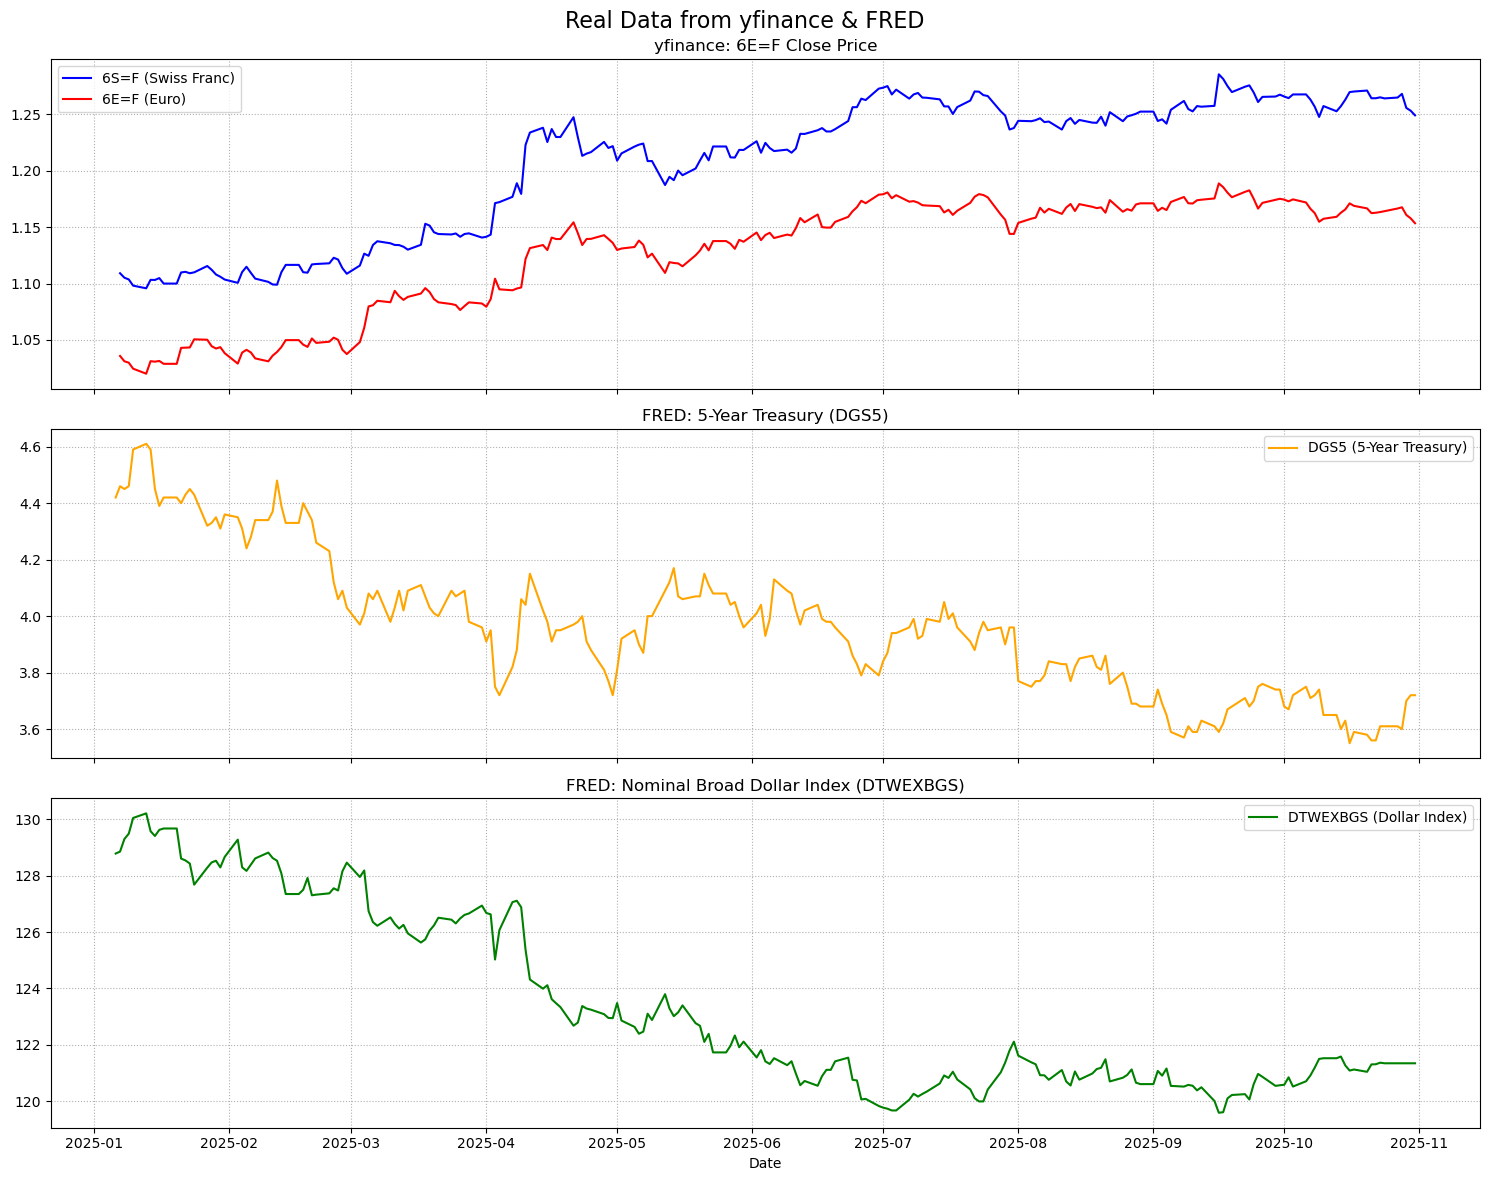

In [19]:
# Cell 15: Real Data Analysis & Visualization

print("--- Loading real data from 'mock_db' ---")

# 1. Load yfinance market data into a DataFrame
df_market_real = pd.DataFrame(mock_db["market_data"])
df_market_real = df_market_real.set_index("timestamp").sort_index()
# Pivot to get tickers as columns
df_market_real = df_market_real.pivot(columns='asset_id', values='close')

# 2. Load FRED macro data into a DataFrame
# We only want the new data, which has a 'series_id' key
df_macro_real = pd.DataFrame([d for d in mock_db["macro_data"] if "series_id" in d])
df_macro_real = df_macro_real.set_index("timestamp").sort_index()
# Pivot from long-form to wide-form (each series is a column)
df_macro_wide = df_macro_real.pivot(columns='series_id', values='value')

# 3. Merge market and macro data

# --- THIS IS THE FIX ---
# Remove timezone info from the yfinance index to match the naive FRED index
df_market_real.index = df_market_real.index.tz_localize(None)
# -----------------------

df_real_combined = pd.merge(df_market_real, df_macro_wide, left_index=True, right_index=True, how="outer")

# 4. Clean data: Forward-fill missing values (e.g., weekends, holidays)
df_real_combined = df_real_combined.ffill()

# --- Analytics ---
print("\n--- Real Data Analytics (describe()) ---")
print(df_real_combined.describe())

# --- Charting ---
print("\n--- Plotting Real Fetched Data ---")

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
fig.suptitle("Real Data from yfinance & FRED", fontsize=16)

# Plot 1: 6S=F (Swiss Franc Future)
ax1.plot(df_real_combined.index, df_real_combined['6S=F'], label="6S=F (Swiss Franc)", color="blue")
ax1.set_title("yfinance: 6S=F Close Price")
ax1.legend()
ax1.grid(True, linestyle=":")

ax1.plot(df_real_combined.index, df_real_combined['6E=F'], label="6E=F (Euro)", color="red")
ax1.set_title("yfinance: 6E=F Close Price")
ax1.legend()
ax1.grid(True, linestyle=":")

# Plot 2: DGS5 (5-Year Treasury)
ax2.plot(df_real_combined.index, df_real_combined['DGS5'], label="DGS5 (5-Year Treasury)", color="orange")
ax2.set_title("FRED: 5-Year Treasury (DGS5)")
ax2.legend()
ax2.grid(True, linestyle=":")

# Plot 3: DTWEXBGS (Dollar Index)
ax3.plot(df_real_combined.index, df_real_combined['DTWEXBGS'], label="DTWEXBGS (Dollar Index)", color="green")
ax3.set_title("FRED: Nominal Broad Dollar Index (DTWEXBGS)")
ax3.legend()
ax3.grid(True, linestyle=":")

plt.xlabel("Date")
plt.tight_layout()
plt.show()

## Conclusion & Next Steps

This notebook successfully translated your multi-domain trading plan into a runnable, cell-by-cell system using a NoSQL-style document model.

**Next Steps**
- Replace mock data with live API inputs.
- Add a true LLM sentiment pipeline.
- Integrate backtesting via `backtrader` or `zipline`.
- Connect final signal to Schwab API for execution.
